In [63]:
import pandas as pd
import pickle
import re
import string
import unicodedata
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans, DBSCAN
import hdbscan
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, silhouette_score, davies_bouldin_score,classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
warnings.filterwarnings('ignore')

In [48]:
# Download necessary resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [19]:
text_dataset = '../datasets/train_data_text.pkl'

X_text = pickle.load(open(text_dataset, 'rb'))

In [20]:
X_text[0]

"\nIn article <93089.204431GRV101@psuvm.psu.edu> Callec Dradja <GRV101@psuvm.psu.edu> writes:\n>I am a bit nervous about posting this beacause it is begining to\n>stray fron the topic of space but then again that doesn't seem to\n>stop alot of other people. :-)\n>\n>With all of this talk about breathing at high pressures, I began\n>to think about the movie Abyss. If you remember, in that movie one\n>of the characters dove to great depths by wearing a suit that used\n>a fluid that carries oxegen as opposed to some sort of gas. Now I\n>have heard that mice can breath this fluid but for some reason, humans\n>are unable to. Does anyone know more details about this?\n>\n>Gregson Vaux\n>\n\nI believe the reason is that the lung diaphram gets too tired to pump\nthe liquid in and out and simply stops breathing after 2-3 minutes.\nSo if your in the vehicle ready to go they better not put you on \nhold, or else!! That's about it. Remember a liquid is several more times\nas dense as a gas by its 

In [21]:
# Initialize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [22]:
print(stop_words)

{'his', "they'd", 're', "should've", "needn't", 'she', 'it', "mustn't", 'needn', 'at', 'no', 'doesn', 'we', 'which', 'he', "couldn't", 'where', 'i', 'through', "you've", 've', "haven't", "isn't", 'in', 'here', 'its', 'or', 'll', 'before', 'being', 'then', "it'll", 'during', 'most', "shouldn't", 'some', "don't", "doesn't", 'again', 'few', 'from', "it's", "i've", 'into', 'up', "aren't", 'yours', 'themselves', 'any', 'shouldn', "you'd", 'o', 'both', "hadn't", 'how', 'yourself', 'of', 'does', 'once', "we'd", 'mightn', 'them', 'there', 'me', 'by', 'am', 'had', 'a', 'the', 'won', "i'm", 'itself', 'wasn', "hasn't", "i'd", 'until', 'ma', 'too', 'hasn', 'your', 'didn', 'an', 'this', 'and', 'hers', 'our', 'those', 'don', 't', 'further', 'as', 'y', 'over', "they've", 'be', 'isn', 'doing', 'can', 'down', "he'd", 'to', 'have', "we'll", 'after', 'all', 'only', 'ours', "mightn't", 'was', 'when', 'yourselves', 'mustn', 'my', 'who', 'himself', 'that', 'hadn', "that'll", 'on', "you'll", "wouldn't", 'the

In [23]:
contraction_map = {
    "can't": "cannot",
    "won't": "will not",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'t": " not",
    "'ve": " have",
    "'m": " am"
}

In [24]:
def expand_contractions(text):
    for contraction, full in contraction_map.items():
        text = re.sub(contraction, full, text)
    return text

In [25]:
def normalize_unicode(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [26]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    
    # Normalize unicode
    text = normalize_unicode(text)
    
    # Expand contractions
    text = expand_contractions(text)

    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove emails
    text = re.sub(r'\S+@\S+', '', text)

    # Remove special characters, numbers, punctuation
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

In [29]:
X_cleaned = [clean_text(doc) for doc in X_text]

In [30]:
X_cleaned[0]

'article callec dradja writes bit nervous posting beacause begining stray fron topic space seem stop alot people talk breathing high pressure began think movie abyss remember movie one character dove great depth wearing suit used fluid carry oxegen opposed sort gas heard mouse breath fluid reason human unable anyone know detail gregson vaux believe reason lung diaphram get tired pump liquid simply stop breathing minute vehicle ready go better put hold else remember liquid several time dense gas nature think depending gas liquid comparision course acurist'

In [31]:
def correct_spelling(text):
    blob = TextBlob(text)
    return str(blob.correct())

In [32]:
def apply_phrase_modeling(token_lists, min_count=5, threshold=10):
    # Build bigram and trigram models
    bigram = Phrases(token_lists, min_count=min_count, threshold=threshold)
    trigram = Phrases(bigram[token_lists], threshold=threshold)
    
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    
    # Apply the models
    bigram_tokens = [bigram_mod[doc] for doc in token_lists]
    trigram_tokens = [trigram_mod[bigram_mod[doc]] for doc in token_lists]
    
    return trigram_tokens

In [33]:
def clean_and_tokenize(text, correct_spelling_enabled=False):
    # Lowercase
    text = text.lower()

    # Normalize unicode
    text = normalize_unicode(text)

    # Expand contractions
    text = expand_contractions(text)

    # Remove URLs and emails
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)

    # Optionally correct spelling
    if correct_spelling_enabled:
        text = correct_spelling(text)

    # Remove special characters and digits
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords and lemmatize
    tokens = [
        lemmatizer.lemmatize(word) for word in tokens
        if word not in stop_words
    ]

    return tokens


In [34]:
def clean_dataset(raw_dataset, correct_spelling_enabled=False, use_phrases=False):
    tokenized_data = [clean_and_tokenize(text, correct_spelling_enabled) for text in raw_dataset]
   
    if use_phrases:
        tokenized_data = apply_phrase_modeling(tokenized_data)

    return [' '.join(tokens) for tokens in tokenized_data]

In [35]:
cleaned_dataset_spell_phrase = clean_dataset(
    X_text,
    correct_spelling_enabled=False,
    use_phrases=True
)

print(cleaned_dataset_spell_phrase)

['article callec dradja writes bit nervous posting beacause begining stray fron topic space seem stop alot people talk breathing high pressure began think movie abyss remember movie one character dove great depth wearing suit used fluid carry oxegen opposed sort gas heard mouse breath fluid reason human unable anyone_know detail gregson vaux believe reason lung diaphram get tired pump liquid simply stop breathing minute vehicle ready go better put hold else remember liquid several_time dense gas nature think depending gas liquid comparision course acurist', 'article r j traff writes_article dariuslecointe_writes question authority proclaim requirement fourth commandment longer relevant modern_christian please believe christian believe law however saved adherence law law exists tell_u sinful sin hence law case refers christian jew believe sin atoned blood_sacrifice animal described old_testament last time heard jewish animal sacrifice christian believe sin atoned blood_sacrifice jesus b

In [36]:
cleaned_dataset_spell_phrase[0]

'article callec dradja writes bit nervous posting beacause begining stray fron topic space seem stop alot people talk breathing high pressure began think movie abyss remember movie one character dove great depth wearing suit used fluid carry oxegen opposed sort gas heard mouse breath fluid reason human unable anyone_know detail gregson vaux believe reason lung diaphram get tired pump liquid simply stop breathing minute vehicle ready go better put hold else remember liquid several_time dense gas nature think depending gas liquid comparision course acurist'

In [47]:
X_cleaned[0]

'article callec dradja writes bit nervous posting beacause begining stray fron topic space seem stop alot people talk breathing high pressure began think movie abyss remember movie one character dove great depth wearing suit used fluid carry oxegen opposed sort gas heard mouse breath fluid reason human unable anyone know detail gregson vaux believe reason lung diaphram get tired pump liquid simply stop breathing minute vehicle ready go better put hold else remember liquid several time dense gas nature think depending gas liquid comparision course acurist'

In [37]:
# --- Vectorization ---
def vectorize_text(texts, method='tfidf'):
    if method == 'tfidf':
        vectorizer = TfidfVectorizer()
        return vectorizer.fit_transform(texts).toarray()
    
    elif method == 'word2vec':
        tokenized = [text.split() for text in texts]
        w2v_model = Word2Vec(sentences=tokenized, vector_size=100, window=5, min_count=1)
        vectors = []
        for tokens in tokenized:
            word_vecs = [w2v_model.wv[token] for token in tokens if token in w2v_model.wv]
            if word_vecs:
                vectors.append(np.mean(word_vecs, axis=0))
            else:
                vectors.append(np.zeros(100))
        return np.array(vectors)

    elif method == 'sentence':
        model = SentenceTransformer('all-MiniLM-L6-v2')
        return model.encode(texts)

In [38]:
# --- Dimensionality Reduction ---
def reduce_dimensions(vectors, method=None, n_components=2):
    if method == 'pca':
        return PCA(n_components=n_components).fit_transform(vectors)
    elif method == 'tsne':
        return TSNE(n_components=n_components).fit_transform(vectors)
    elif method == 'umap':
        return umap.UMAP(n_components=n_components).fit_transform(vectors)
    return vectors  # no reduction

In [64]:
# --- Clustering ---
def apply_clustering(vectors, method='kmeans', n_clusters=5):
    if method == 'kmeans':
        return KMeans(n_clusters=n_clusters, random_state=42).fit_predict(vectors)
    elif method == 'dbscan':
        return DBSCAN(eps=0.5, min_samples=5).fit_predict(vectors)
    elif method == 'hdbscan':
        return hdbscan.HDBSCAN(min_cluster_size=5).fit_predict(vectors)

In [73]:
# --- Classification ---
def evaluate_classifiers(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=500),
        "Random Forest": RandomForestClassifier(),
        "SVM": SVC(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    }

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        accuracy = accuracy_score(y_test, y_pred)
        print(f"\n{name}:")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(classification_report(y_test, y_pred))
        
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{name.upper()} - Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

In [69]:
# --- Pipeline Runner ---
def run_pipeline(cleaned_texts, vector_method='tfidf', reduce_method=None, cluster_method='kmeans'):
    vectors = vectorize_text(cleaned_texts, method=vector_method)
    reduced_vectors = reduce_dimensions(vectors, method=reduce_method)
    labels = apply_clustering(reduced_vectors, method=cluster_method)
    
    print("Silhouette Score:", silhouette_score(reduced_vectors, labels))
    print("Davies-Bouldin Score:", davies_bouldin_score(reduced_vectors, labels))

    reducer_2d = PCA(n_components=2) if reduced_vectors.shape[1] > 2 else None
    X_2d = reducer_2d.fit_transform(reduced_vectors) if reducer_2d else reduced_vectors

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels, palette='tab10', s=40)
    plt.title('Cluster Visualization')
    plt.show()
    
    print(f"\nClustering done using {cluster_method}. Number of clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")
    evaluate_classifiers(reduced_vectors, labels)

Silhouette Score: 0.44873384
Davies-Bouldin Score: 0.7678368633114803


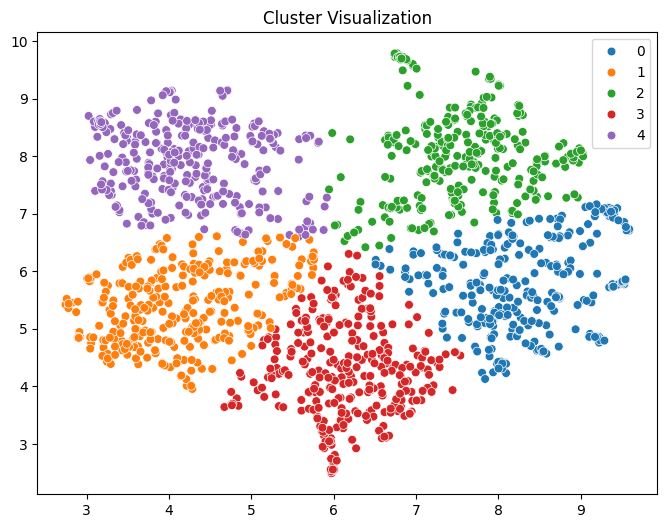


Clustering done using kmeans. Number of clusters: 5

Logistic Regression:
  Precision: 0.9897
  Recall:    0.9903
  Accuracy:  0.9900
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        54
           1       1.00      1.00      1.00        63
           2       1.00      0.98      0.99        66
           3       0.99      0.99      0.99        67
           4       1.00      1.00      1.00        50

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



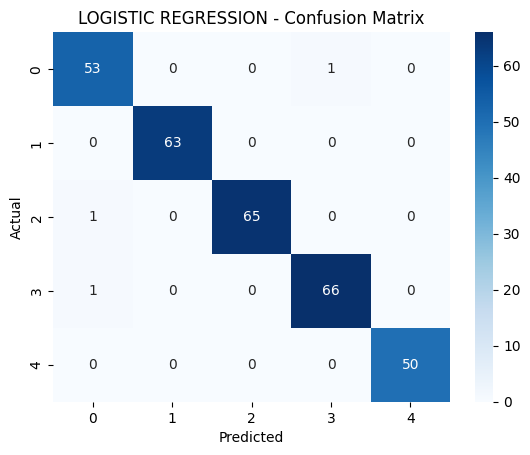


Random Forest:
  Precision: 0.9942
  Recall:    0.9926
  Accuracy:  0.9933
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        54
           1       1.00      1.00      1.00        63
           2       1.00      1.00      1.00        66
           3       0.97      1.00      0.99        67
           4       1.00      1.00      1.00        50

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



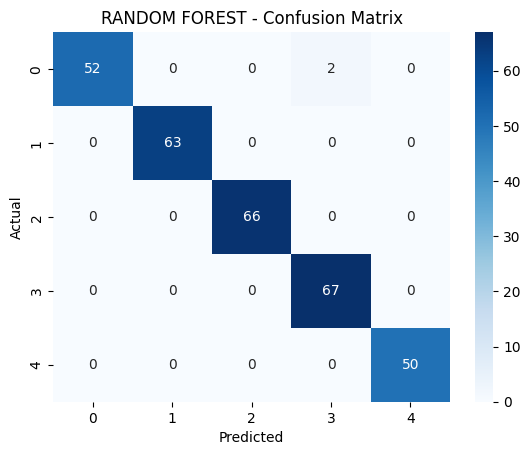


SVM:
  Precision: 0.9759
  Recall:    0.9775
  Accuracy:  0.9767
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        54
           1       0.98      1.00      0.99        63
           2       0.98      0.95      0.97        66
           3       0.98      0.97      0.98        67
           4       0.98      1.00      0.99        50

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



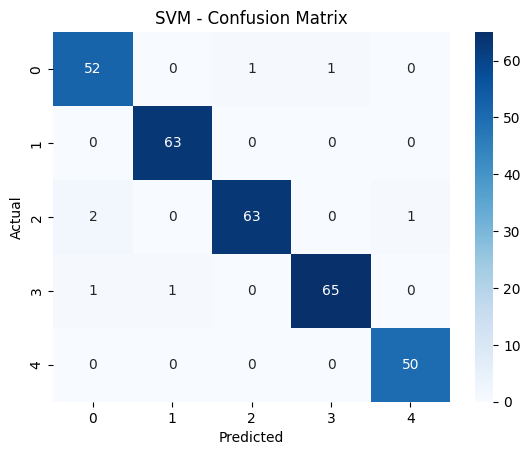


XGBoost:
  Precision: 0.9874
  Recall:    0.9864
  Accuracy:  0.9867
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        54
           1       1.00      0.98      0.99        63
           2       0.99      1.00      0.99        66
           3       0.97      0.99      0.98        67
           4       1.00      1.00      1.00        50

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



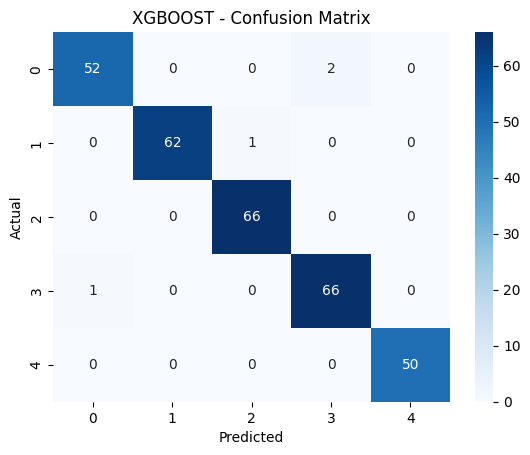

In [74]:
run_pipeline(
    cleaned_dataset_spell_phrase,
    vector_method='tfidf',     # Options: 'tfidf', 'word2vec', 'sentence'
    reduce_method='umap',         # Options: None, 'pca', 'tsne', 'umap'
    cluster_method='kmeans'      # Options: 'kmeans', 'dbscan', 'hdbscan'
)

Silhouette Score: 0.52900666
Davies-Bouldin Score: 0.6577931388255921


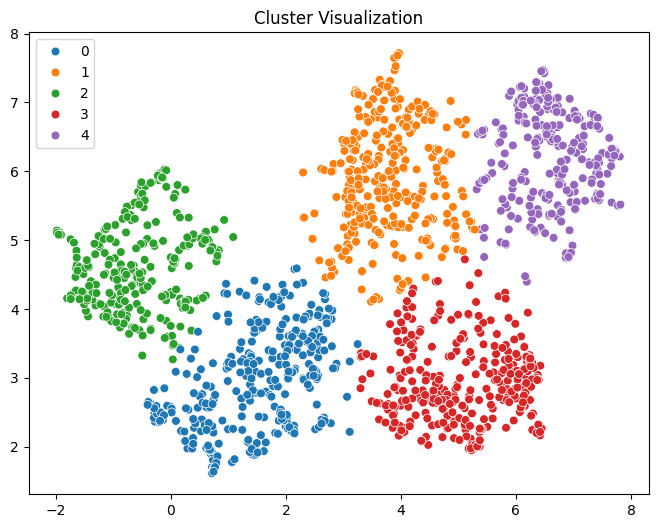


Clustering done using kmeans. Number of clusters: 5

Logistic Regression:
  Precision: 0.9873
  Recall:    0.9868
  Accuracy:  0.9867
              precision    recall  f1-score   support

           0       0.98      0.97      0.98        66
           1       0.97      1.00      0.98        63
           2       0.98      0.98      0.98        57
           3       1.00      0.98      0.99        55
           4       1.00      1.00      1.00        59

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



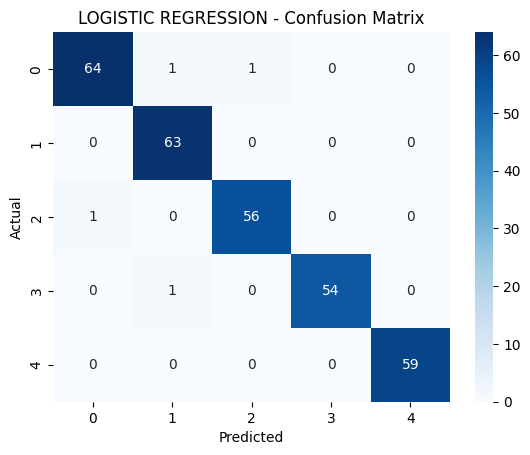


Random Forest:
  Precision: 0.9863
  Recall:    0.9865
  Accuracy:  0.9867
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        66
           1       0.98      0.98      0.98        63
           2       0.98      1.00      0.99        57
           3       0.98      0.96      0.97        55
           4       0.98      1.00      0.99        59

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



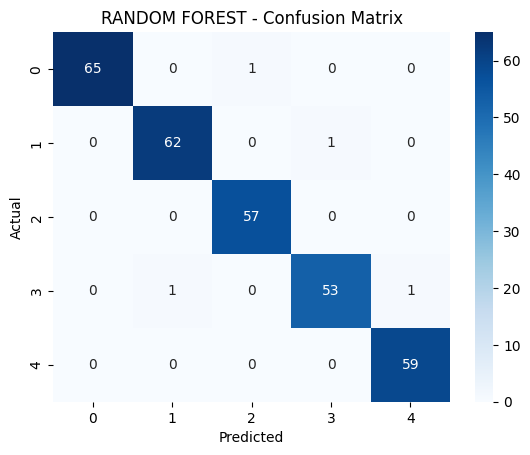


SVM:
  Precision: 0.9871
  Recall:    0.9869
  Accuracy:  0.9867
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        66
           1       0.97      1.00      0.98        63
           2       0.97      1.00      0.98        57
           3       1.00      0.98      0.99        55
           4       1.00      0.98      0.99        59

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



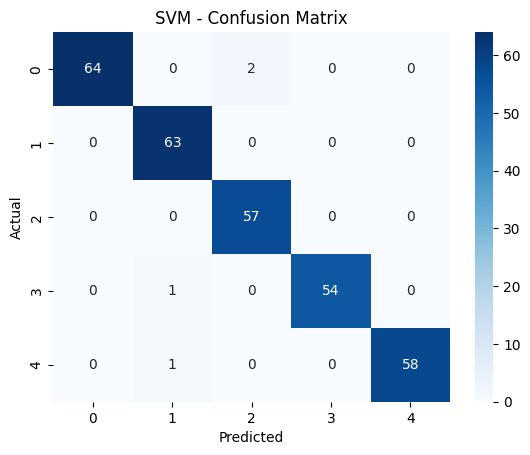


XGBoost:
  Precision: 0.9833
  Recall:    0.9835
  Accuracy:  0.9833
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        66
           1       0.97      0.98      0.98        63
           2       0.98      1.00      0.99        57
           3       0.98      0.96      0.97        55
           4       0.98      1.00      0.99        59

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



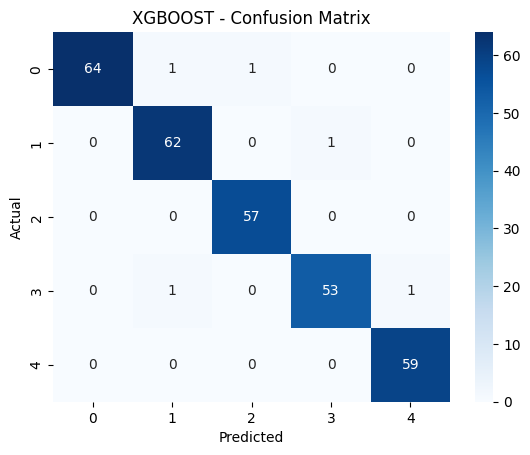

In [75]:
run_pipeline(
    cleaned_dataset_spell_phrase,
    vector_method='sentence',     # Options: 'tfidf', 'word2vec', 'sentence'
    reduce_method='umap',         # Options: None, 'pca', 'tsne', 'umap'
    cluster_method='kmeans'      # Options: 'kmeans', 'dbscan', 'hdbscan'
)

Silhouette Score: 0.54442817
Davies-Bouldin Score: 0.5757854275978759


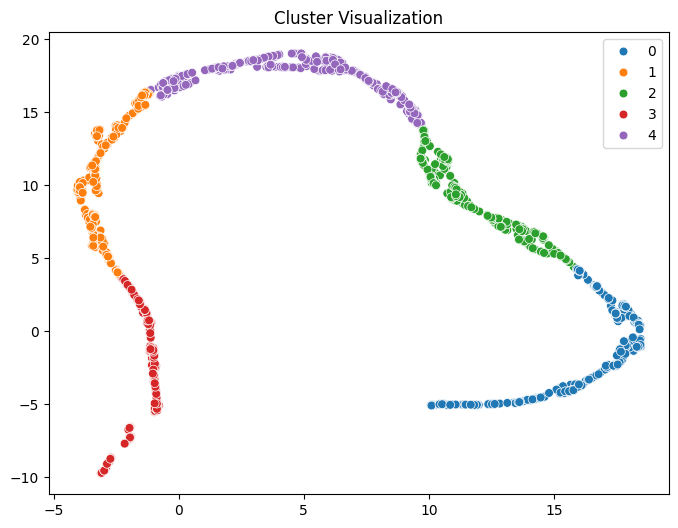


Clustering done using kmeans. Number of clusters: 5

Logistic Regression:
  Precision: 0.9964
  Recall:    0.9959
  Accuracy:  0.9967
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       0.98      1.00      0.99        54
           2       1.00      1.00      1.00        60
           3       1.00      0.98      0.99        49
           4       1.00      1.00      1.00        57

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



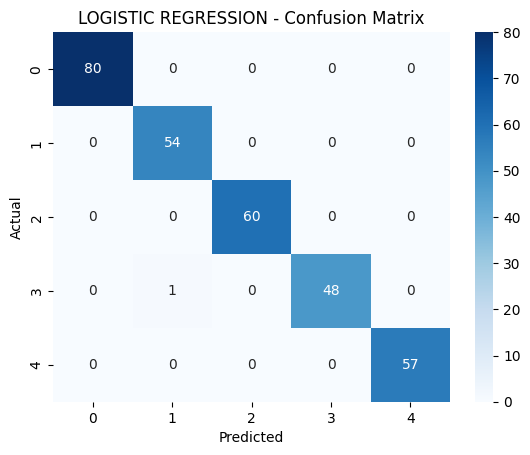


Random Forest:
  Precision: 0.9967
  Recall:    0.9965
  Accuracy:  0.9967
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        54
           2       0.98      1.00      0.99        60
           3       1.00      1.00      1.00        49
           4       1.00      0.98      0.99        57

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



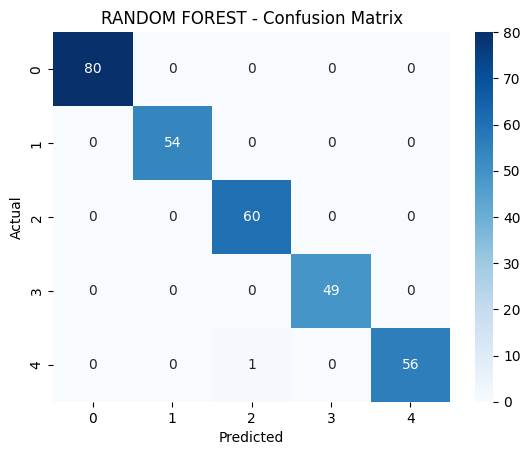


SVM:
  Precision: 0.9829
  Recall:    0.9818
  Accuracy:  0.9833
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       0.96      1.00      0.98        54
           2       1.00      0.95      0.97        60
           3       1.00      0.96      0.98        49
           4       0.95      1.00      0.97        57

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



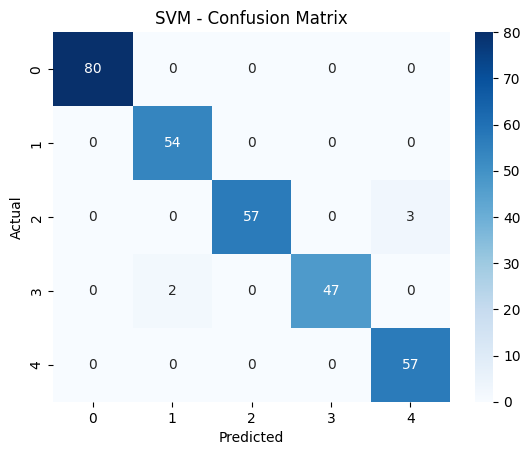


XGBoost:
  Precision: 0.9967
  Recall:    0.9965
  Accuracy:  0.9967
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        54
           2       0.98      1.00      0.99        60
           3       1.00      1.00      1.00        49
           4       1.00      0.98      0.99        57

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



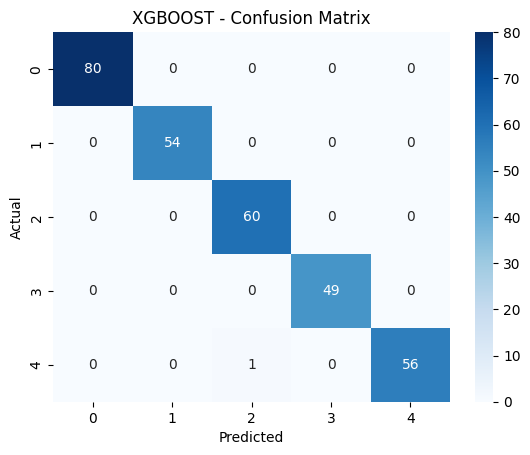

In [76]:
run_pipeline(
    cleaned_dataset_spell_phrase,
    vector_method='word2vec',     # Options: 'tfidf', 'word2vec', 'sentence'
    reduce_method='umap',         # Options: None, 'pca', 'tsne', 'umap'
    cluster_method='kmeans'      # Options: 'kmeans', 'dbscan', 'hdbscan'
)

Silhouette Score: 0.49460873
Davies-Bouldin Score: 0.6007372218785847


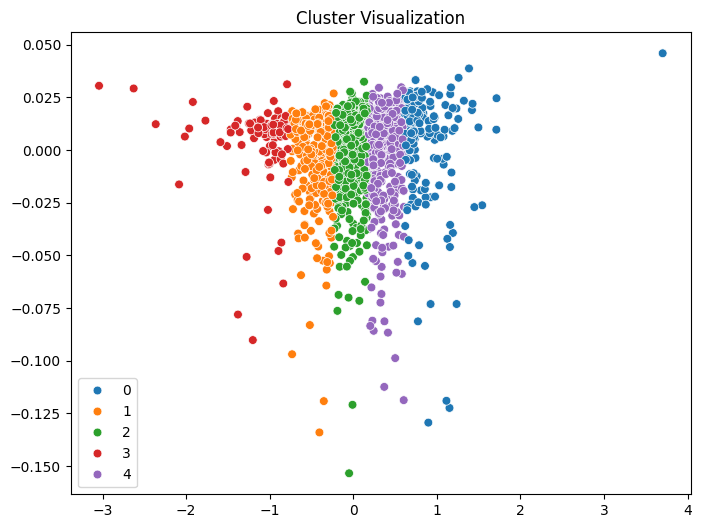


Clustering done using kmeans. Number of clusters: 5

Logistic Regression:
  Precision: 0.9453
  Recall:    0.8667
  Accuracy:  0.9267
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        48
           1       0.86      0.99      0.92        69
           2       0.97      1.00      0.98        85
           3       1.00      0.54      0.70        24
           4       0.90      0.97      0.94        74

    accuracy                           0.93       300
   macro avg       0.95      0.87      0.89       300
weighted avg       0.93      0.93      0.92       300



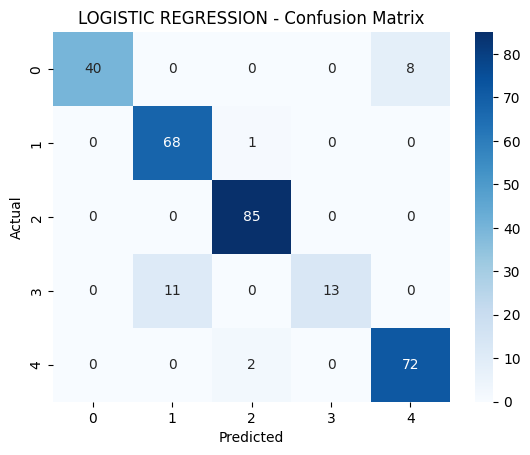


Random Forest:
  Precision: 0.9959
  Recall:    0.9973
  Accuracy:  0.9967
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        48
           1       1.00      1.00      1.00        69
           2       1.00      1.00      1.00        85
           3       1.00      1.00      1.00        24
           4       1.00      0.99      0.99        74

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



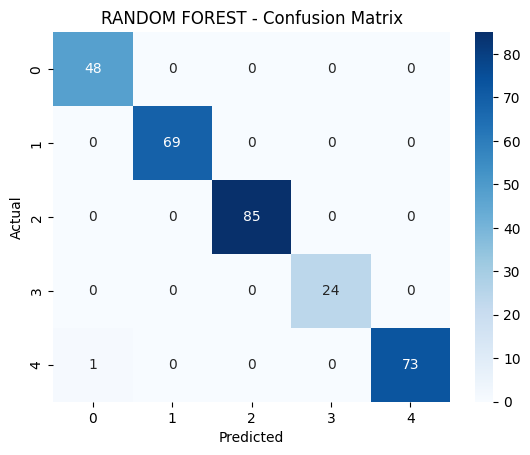


SVM:
  Precision: 0.9890
  Recall:    0.9786
  Accuracy:  0.9867
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       0.95      1.00      0.97        69
           2       1.00      0.98      0.99        85
           3       1.00      0.92      0.96        24
           4       1.00      1.00      1.00        74

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



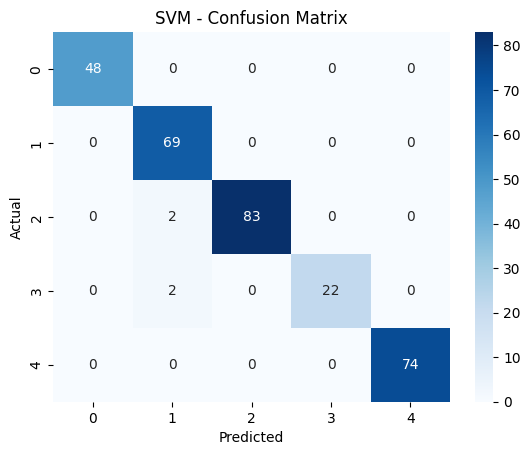


XGBoost:
  Precision: 0.9879
  Recall:    0.9944
  Accuracy:  0.9933
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        48
           1       1.00      0.99      0.99        69
           2       1.00      1.00      1.00        85
           3       0.96      1.00      0.98        24
           4       1.00      0.99      0.99        74

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



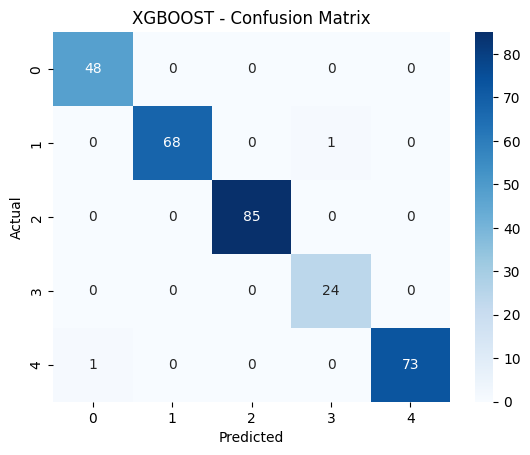

In [77]:
run_pipeline(
    cleaned_dataset_spell_phrase,
    vector_method='word2vec',     # Options: 'tfidf', 'word2vec', 'sentence'
    reduce_method='pca',         # Options: None, 'pca', 'tsne', 'umap'
    cluster_method='kmeans'      # Options: 'kmeans', 'dbscan', 'hdbscan'
)

Silhouette Score: 0.44323048
Davies-Bouldin Score: 0.7493268904083368


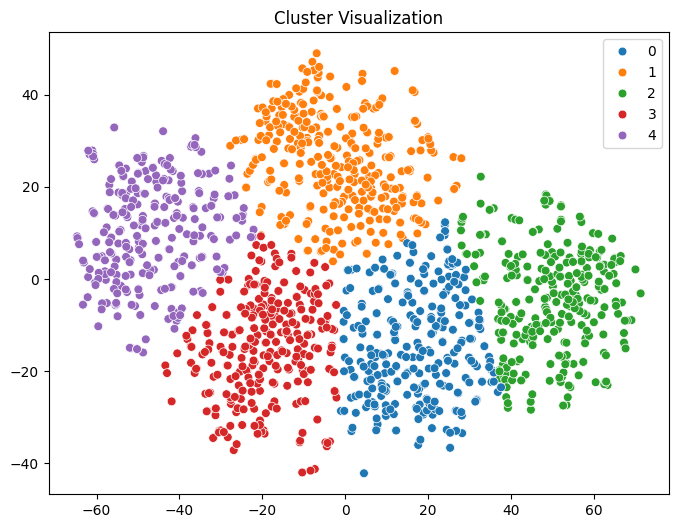


Clustering done using kmeans. Number of clusters: 5

Logistic Regression:
  Precision: 0.9937
  Recall:    0.9931
  Accuracy:  0.9933
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        57
           1       1.00      0.98      0.99        59
           2       0.98      1.00      0.99        65
           3       0.98      1.00      0.99        60
           4       1.00      1.00      1.00        59

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



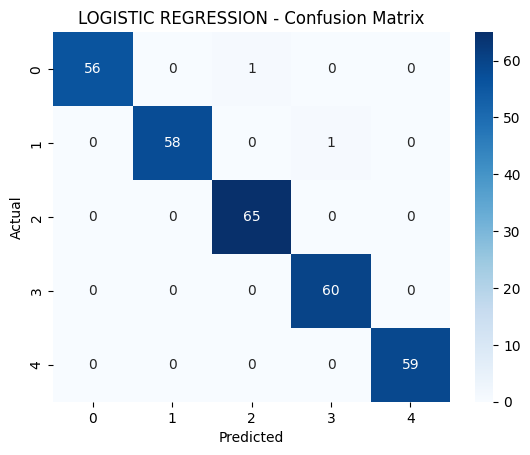


Random Forest:
  Precision: 0.9799
  Recall:    0.9802
  Accuracy:  0.9800
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        57
           1       0.98      0.97      0.97        59
           2       0.98      0.97      0.98        65
           3       0.98      1.00      0.99        60
           4       0.98      0.98      0.98        59

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



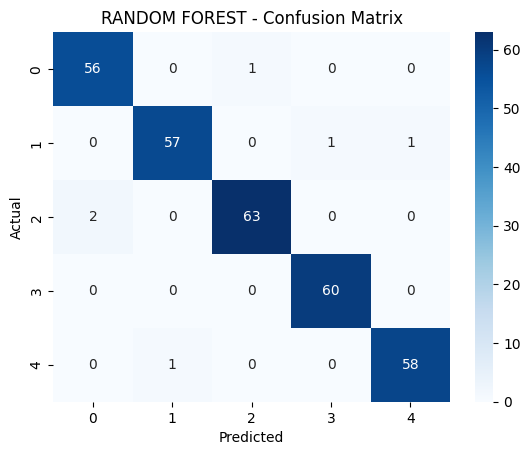


SVM:
  Precision: 0.9834
  Recall:    0.9842
  Accuracy:  0.9833
              precision    recall  f1-score   support

           0       0.93      0.98      0.96        57
           1       1.00      1.00      1.00        59
           2       0.98      0.94      0.96        65
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00        59

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



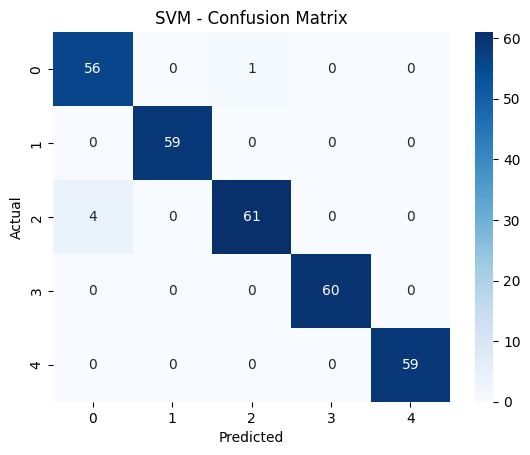


XGBoost:
  Precision: 0.9733
  Recall:    0.9741
  Accuracy:  0.9733
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        57
           1       0.97      0.98      0.97        59
           2       0.98      0.94      0.96        65
           3       1.00      0.98      0.99        60
           4       0.97      0.98      0.97        59

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



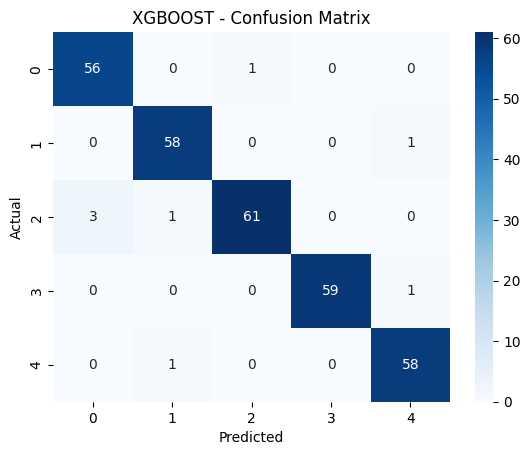

In [78]:
run_pipeline(
    cleaned_dataset_spell_phrase,
    vector_method='sentence',     # Options: 'tfidf', 'word2vec', 'sentence'
    reduce_method='tsne',         # Options: None, 'pca', 'tsne', 'umap'
    cluster_method='kmeans'      # Options: 'kmeans', 'dbscan', 'hdbscan'
)